In [74]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
os.environ["WANDB_START_METHOD"] = "thread"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import torch
import numpy as np
import random

def seed_everything():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

## Load dataset

In [76]:
from personalized_nlp.datasets.humor.humor import HumorDataModule


In [77]:
humor_module = HumorDataModule(normalize=True)
humor_module.prepare_data()

humor_module.setup()

In [102]:
TEST_FOLD = 0 
test_text_ids = []
for batch in humor_module.test_dataloader(test_fold=TEST_FOLD):
    test_text_ids.extend(batch[0]['text_ids'].tolist())
humor_module.data.iloc[test_text_ids]

,text_id,text,split
17,16235575870758912,"Mamá ¿por qué yo soy negro, tu amarilla y papá...",future2
21,16599228113494016,Si tu ex te dice: ¡Nunca encontrarás a alguien...,future2
58,21304298788888576,Si estás tirando y tu pareja te pide hacer el ...,future2
112,24242659388293120,-A esa le dicen la Maruchan -¿Por qué? -Porque...,future2
125,24898356400623616,¿Será verdad que los vegetarianos no pueden te...,future2
...,...,...,...
14866,496676658204921857,"¿Te desmayaste? No, me estoy reiniciando.",future2
14908,497025804170444800,"-Papi, cómo se hacen los niños? -Mira Jaimito,...",future2
15021,497469850764472321,"RT @ParejaCursis: Si fallaste ayer, no importa...",future2
15037,497485848225775617,"RT @FrassesDiarias: ""Las mejores sonrisas son ...",future2


array([[<AxesSubplot:title={'center':'is_funny_bias'}>]], dtype=object)

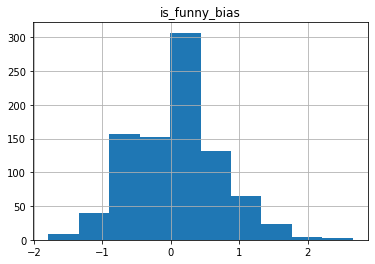

In [24]:
df = humor_module.annotations_with_data.loc[humor_module.annotations_with_data.split == 'past']
columns = ['is_funny']
text_means = df.groupby('text_id').mean().loc[:, columns]
text_stds = df.groupby('text_id').std().loc[:, columns]

df = df.join(text_means, rsuffix='_mean', on='text_id').join(
    text_stds, rsuffix='_std', on='text_id')

for col in columns:
    df[col + '_z_score'] = (df[col] - df[col + '_mean']) / (df[col + '_std'] + 1e-8)

annotator_biases = df.groupby('annotator_id').mean(
).loc[:, [col + '_z_score' for col in columns]]

annotator_biases.columns = [col + '_bias' for col in columns]
annotator_biases.hist()


(0.0, 100.0)

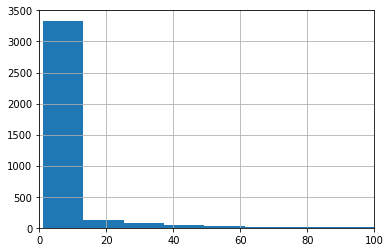

In [31]:
import matplotlib.pyplot as plt
humor_module.annotations_with_data.annotator_id.value_counts().hist(bins=200)
plt.xlim(0, 100)

## Results analysis

<AxesSubplot:xlabel='min_word_count', ylabel='test_loss'>

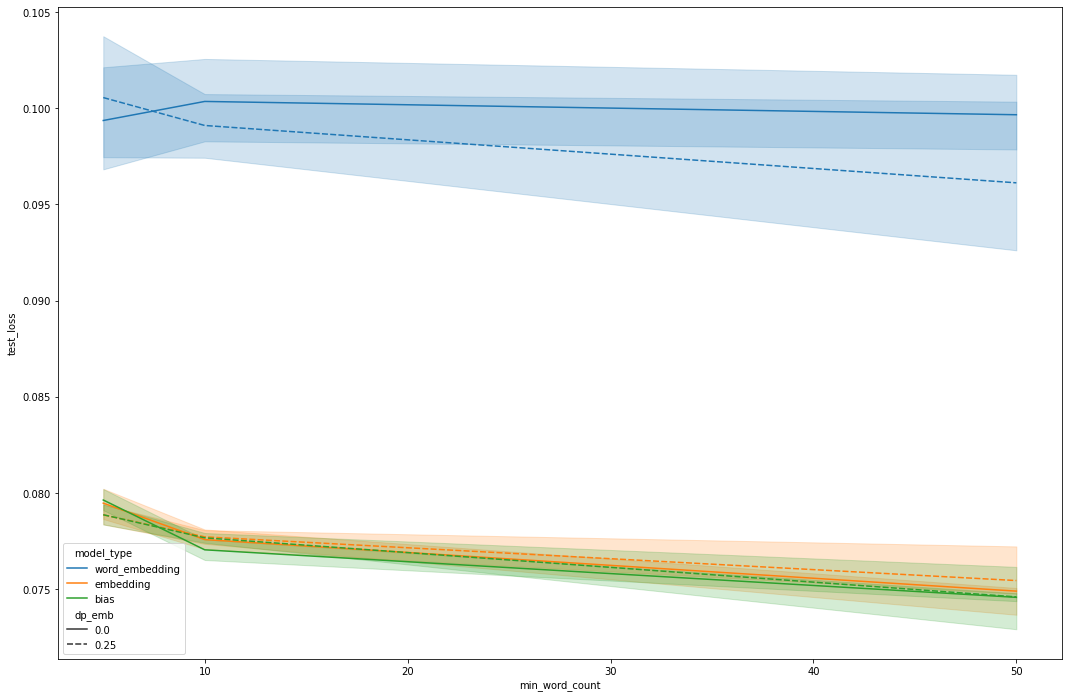

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,12))
hparams_df = pd.read_csv('./data/hparams/hparams_search.csv')
hparams_df = hparams_df[hparams_df.words_per_text > 5]
hparams_df = hparams_df[hparams_df.embeddings_type.isin(['mpnet', 'xlmr'])]

sns.lineplot(data=hparams_df, x='min_word_count', y='test_loss', hue='model_type', style='dp_emb')

In [71]:
hparams_df[hparams_df.embeddings_type == 'mpnet'].groupby(['words_per_text', 'min_word_count', 'dp_emb', 'model_type'])['test_r2_is_funny'].mean()

words_per_text  min_word_count  dp_emb  model_type    
10              5               0.00    bias              0.282560
                                        embedding         0.293642
                                        word_embedding    0.161087
                                0.25    bias              0.282266
                                        embedding         0.284219
                                        word_embedding    0.167597
                10              0.00    bias              0.312338
                                        embedding         0.314500
                                        word_embedding    0.162053
                                0.25    bias              0.289358
                                        embedding         0.294060
                                        word_embedding    0.151156
                50              0.00    bias              0.344809
                                        embedding         0.341609
       

## Final results - no user folding

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,12))
hparams_df = pd.read_csv('./data/hparams/hparams_search.csv')
hparams_df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,dataset,dp_emb,...,epoch,test_loss,test_r2_is_funny,test_r2_mean,train_loss_epoch,train_loss_step,trainer/global_step,valid_loss,valid_r2_is_funny,valid_r2_mean
0,spooky-ghoul-1997,running,-,satyrr,NaN,2021-10-31T23:05:54.000Z,13,NaN,HumorDataModule,0.25,...,13,NaN,NaN,NaN,0.076950,0.074207,111,0.082701,0.242398,0.242398
1,spooky-cape-1996,finished,-,satyrr,NaN,2021-10-31T23:05:36.000Z,15,NaN,HumorDataModule,0.25,...,14,0.081616,0.255008,0.255008,0.073453,0.076139,120,0.081730,0.251598,0.251598
2,terrifying-goblin-1995,finished,-,satyrr,NaN,2021-10-31T23:05:10.000Z,19,NaN,HumorDataModule,0.25,...,14,0.087828,0.184598,0.184598,0.091719,0.097149,120,0.090940,0.175373,0.175373
3,strange-ritual-1994,finished,-,satyrr,NaN,2021-10-31T23:04:49.000Z,18,NaN,HumorDataModule,0.25,...,14,0.091393,0.149946,0.149946,0.095064,0.098314,120,0.093914,0.147265,0.147265
4,trembling-phantom-1993,finished,-,satyrr,NaN,2021-10-31T23:04:28.000Z,18,NaN,HumorDataModule,0.25,...,14,0.089098,0.171634,0.171634,0.093220,0.100448,120,0.092317,0.161997,0.161997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,dire-sorcery-5,finished,-,satyrr,NaN,2021-10-31T16:11:26.000Z,5,NaN,HumorDataModule,0.00,...,14,0.080579,0.278625,0.278625,0.056865,0.058181,120,0.082477,0.265944,0.265944
1993,paranormal-cat-4,finished,-,satyrr,NaN,2021-10-31T16:11:19.000Z,5,NaN,HumorDataModule,0.00,...,14,0.079561,0.287823,0.287823,0.056160,0.056408,120,0.081766,0.272242,0.272242
1994,ghostly-horseman-3,finished,-,satyrr,NaN,2021-10-31T16:11:13.000Z,5,NaN,HumorDataModule,0.00,...,14,0.079448,0.288666,0.288666,0.055672,0.058739,120,0.081456,0.274920,0.274920
1995,supernatural-seance-2,finished,-,satyrr,NaN,2021-10-31T16:11:06.000Z,5,NaN,HumorDataModule,0.00,...,14,0.079865,0.285194,0.285194,0.055827,0.059454,120,0.082021,0.269933,0.269933


<Figure size 1296x864 with 0 Axes>